# Inicio do projeto da Tech Challenge Fase 3 - Machine Learning Engineering

    -------------------------------------------------------

# Modelagem Supervisionada

1. Definir objetivo
2. Exploração estatistica
3. Selecionar features para o classificador
4. Criação do classificador
5. Construção de sample
6. Treinando o modelo
7. Métricas de eficácia

### Bibliotecas

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

### Definição do ambiente em spark

In [2]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Inicializa a sessão
spark = SparkSession.builder \
    .appName("AnaliseVoos") \
    .config("spark.driver.host", "127.0.0.1") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/08 15:24:26 WARN Utils: Your hostname, Gagui, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/01/08 15:24:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/08 15:24:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Carregando os dados

In [3]:
#Carregando os arquivos CSV em DataFrames
df_flights = spark.read.csv("flights.csv", header=True, inferSchema=True)

df_airports = spark.read.csv("airports.csv", header=True, inferSchema=True)

df_airlines = spark.read.csv("airlines.csv", header=True, inferSchema=True)

In [4]:
# 1. Preparação das tabelas de referência
df_airlines_ref = df_airlines.select(
    F.col("IATA_CODE").alias("AIRLINE_KEY"),
    F.col("AIRLINE").alias("AIRLINE_NAME")
)

df_airp_ref = df_airports.select(
    F.col("IATA_CODE").alias("PK_AIRPORT"), # Chave primária do aeroporto
    F.col("AIRPORT").alias("AIRPORT_NAME_FULL"), # Nome por extenso
    F.col("CITY"),
    F.col("STATE"),
    F.col("COUNTRY"),
    F.col("LATITUDE"),
    F.col("LONGITUDE")
)

# 2. Joins em Cadeia
# Join 1: Airlines
df_passo1 = df_flights.join(df_airlines_ref, df_flights.AIRLINE == df_airlines_ref.AIRLINE_KEY, "left").drop("AIRLINE_KEY")

# Join 2: Origem
df_passo2 = df_passo1.join(
    df_airp_ref.select(
        F.col("PK_AIRPORT"),
        F.col("AIRPORT_NAME_FULL").alias("ORIGIN_AIRPORT_NAME"),
        F.col("CITY").alias("ORIGIN_CITY"),
        F.col("STATE").alias("ORIGIN_STATE"),
        F.col("COUNTRY").alias("ORIGIN_COUNTRY"),
        F.col("LATITUDE").alias("ORIGIN_LATITUDE"),
        F.col("LONGITUDE").alias("ORIGIN_LONGITUDE")
    ),
    df_passo1.ORIGIN_AIRPORT == F.col("PK_AIRPORT"), "left"
).drop("PK_AIRPORT")

# Join 3: Destino
df_final = df_passo2.join(
    df_airp_ref.select(
        F.col("PK_AIRPORT"),
        F.col("AIRPORT_NAME_FULL").alias("DESTINATION_AIRPORT_NAME"),
        F.col("CITY").alias("DEST_CITY"),
        F.col("STATE").alias("DEST_STATE"),
        F.col("COUNTRY").alias("DEST_COUNTRY"),
        F.col("LATITUDE").alias("DEST_LATITUDE"),
        F.col("LONGITUDE").alias("DEST_LONGITUDE")
    ),
    df_passo2.DESTINATION_AIRPORT == F.col("PK_AIRPORT"), "left"
).drop("PK_AIRPORT")

# 3. Seleção de TODAS as colunas solicitadas na ordem correta
colunas_finais = [
    "YEAR", "MONTH", "DAY", "DAY_OF_WEEK", "AIRLINE", "AIRLINE_NAME", "FLIGHT_NUMBER", "TAIL_NUMBER",
    "ORIGIN_AIRPORT", "ORIGIN_AIRPORT_NAME", "ORIGIN_CITY", "ORIGIN_STATE", "ORIGIN_COUNTRY", "ORIGIN_LATITUDE", "ORIGIN_LONGITUDE",
    "DESTINATION_AIRPORT", "DESTINATION_AIRPORT_NAME", "DEST_CITY", "DEST_STATE", "DEST_COUNTRY", "DEST_LATITUDE", "DEST_LONGITUDE",
    "SCHEDULED_DEPARTURE", "DEPARTURE_TIME", "DEPARTURE_DELAY", "TAXI_OUT", "WHEELS_OFF", "SCHEDULED_TIME", 
    "ELAPSED_TIME", "AIR_TIME", "DISTANCE", "WHEELS_ON", "TAXI_IN", "SCHEDULED_ARRIVAL", "ARRIVAL_TIME", 
    "ARRIVAL_DELAY", "DIVERTED", "CANCELLED", "CANCELLATION_REASON", "AIR_SYSTEM_DELAY", "SECURITY_DELAY", 
    "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"
]

df_resultado = df_final.select(colunas_finais)

# 4. Verificação de Integridade
print(f"Contagem Original: {df_flights.count()}")
print(f"Contagem Final:    {df_resultado.count()}")

Contagem Original: 5819079


Contagem Final:    5819079


### 1. Objetivo

- Criar um classificar baseado em randomFlorest para previsão de atraso de voos

### 2. EDA

#### 2.1 Verificando quantidade de nulos

In [5]:
from pyspark.sql import functions as F

cols = [
    "YEAR", "MONTH", "DAY", "DAY_OF_WEEK", "AIRLINE", "AIRLINE_NAME", "FLIGHT_NUMBER", "TAIL_NUMBER",
    "ORIGIN_AIRPORT", "ORIGIN_AIRPORT_NAME", "ORIGIN_CITY", "ORIGIN_STATE", "ORIGIN_COUNTRY", 
    "ORIGIN_LATITUDE", "ORIGIN_LONGITUDE",
    "DESTINATION_AIRPORT", "DESTINATION_AIRPORT_NAME", "DEST_CITY", "DEST_STATE", "DEST_COUNTRY", 
    "DEST_LATITUDE", "DEST_LONGITUDE",
    "SCHEDULED_DEPARTURE", "DEPARTURE_TIME", "DEPARTURE_DELAY", "TAXI_OUT", "WHEELS_OFF", "SCHEDULED_TIME",
    "ELAPSED_TIME", "AIR_TIME", "DISTANCE", "WHEELS_ON", "TAXI_IN", "SCHEDULED_ARRIVAL", "ARRIVAL_TIME",
    "ARRIVAL_DELAY", "DIVERTED", "CANCELLED", "CANCELLATION_REASON", "AIR_SYSTEM_DELAY", "SECURITY_DELAY",
    "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"
]

null_counts = df_resultado.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in cols
])

null_counts.show(truncate=False)


26/01/08 15:25:01 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+-----+---+-----------+-------+------------+-------------+-----------+--------------+-------------------+-----------+------------+--------------+---------------+----------------+-------------------+------------------------+---------+----------+------------+-------------+--------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|AIRLINE_NAME|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|ORIGIN_AIRPORT_NAME|ORIGIN_CITY|ORIGIN_STATE|ORIGIN_COUNTRY|ORIGIN_LATITUDE|ORIGIN_LONGITUDE|DESTINATION_AIRPORT|DESTINATION_AIRPORT_NAME|DEST_CITY|DEST_STATE|DEST_COUNTRY|DEST_LATITUDE|DEST_LONGITUDE|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|W

In [6]:
total = df_resultado.count()

null_percent = df_resultado.select([
    (F.count(F.when(F.col(c).isNull(), c)) / F.lit(total) * 100).alias(c)
    for c in cols
])

null_percent.show(truncate=False)


+----+-----+---+-----------+-------+------------+-------------+------------------+--------------+-------------------+----------------+----------------+----------------+-----------------+-----------------+-------------------+------------------------+----------------+----------------+----------------+----------------+----------------+-------------------+------------------+------------------+------------------+------------------+---------------------+------------------+------------------+--------+------------------+------------------+-----------------+------------------+------------------+--------+---------+-------------------+-----------------+-----------------+-----------------+-------------------+-----------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|AIRLINE_NAME|FLIGHT_NUMBER|TAIL_NUMBER       |ORIGIN_AIRPORT|ORIGIN_AIRPORT_NAME|ORIGIN_CITY     |ORIGIN_STATE    |ORIGIN_COUNTRY  |ORIGIN_LATITUDE  |ORIGIN_LONGITUDE |DESTINATION_AIRPORT|DESTINATION_AIRPORT_NAME|DEST_CITY       |DEST_STAT

Variaveis com grande percentual de nulos:

-   CANCELLATION_REASON|AIR_SYSTEM_DELAY |SECURITY_DELAY   |AIRLINE_DELAY    |LATE_AIRCRAFT_DELAY|WEATHER_DELAY

### 2.2 Exploração estatistica

Verificando a distribuição dos dados com boxplot

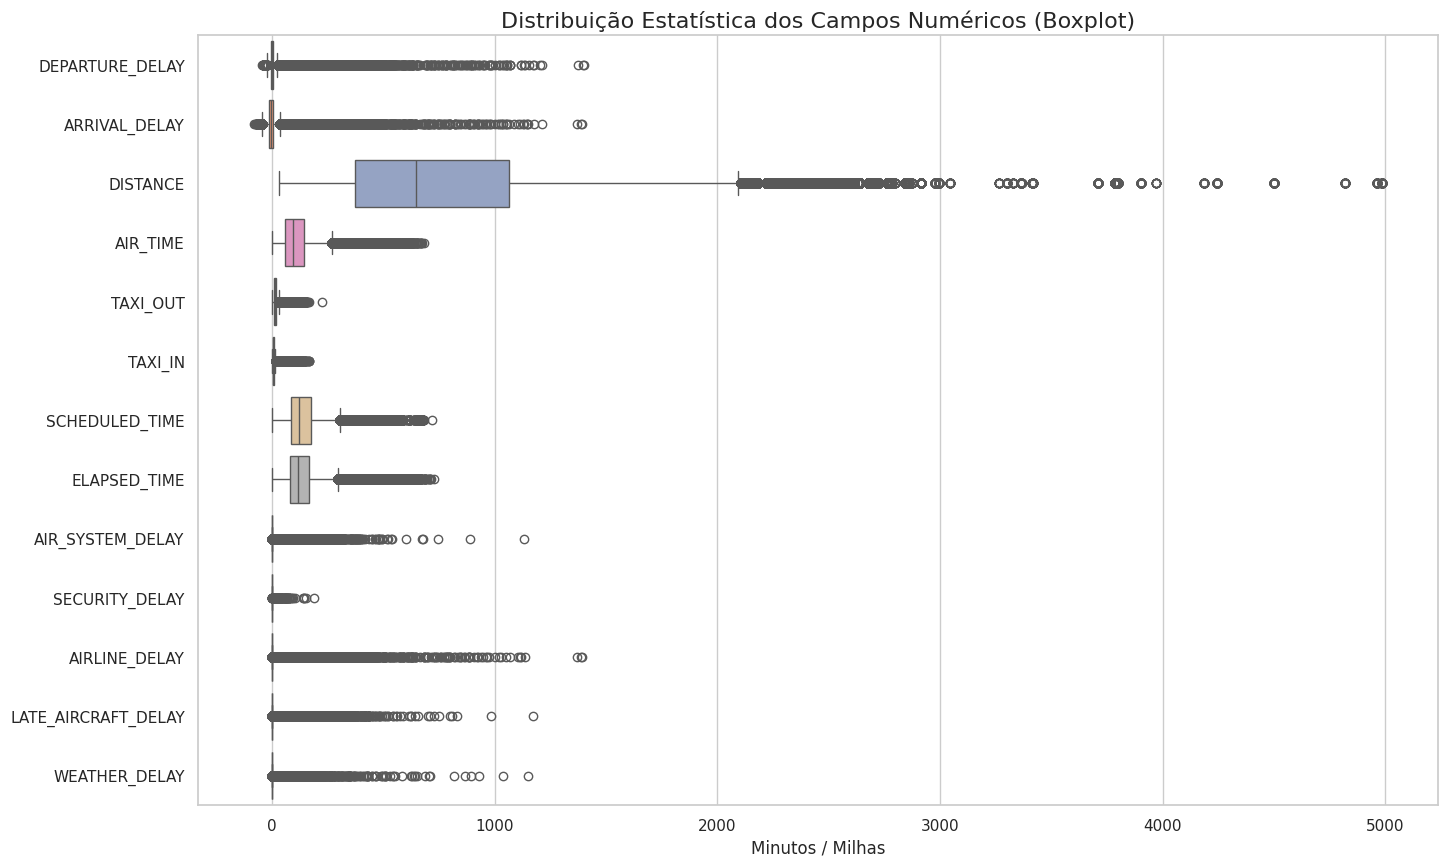

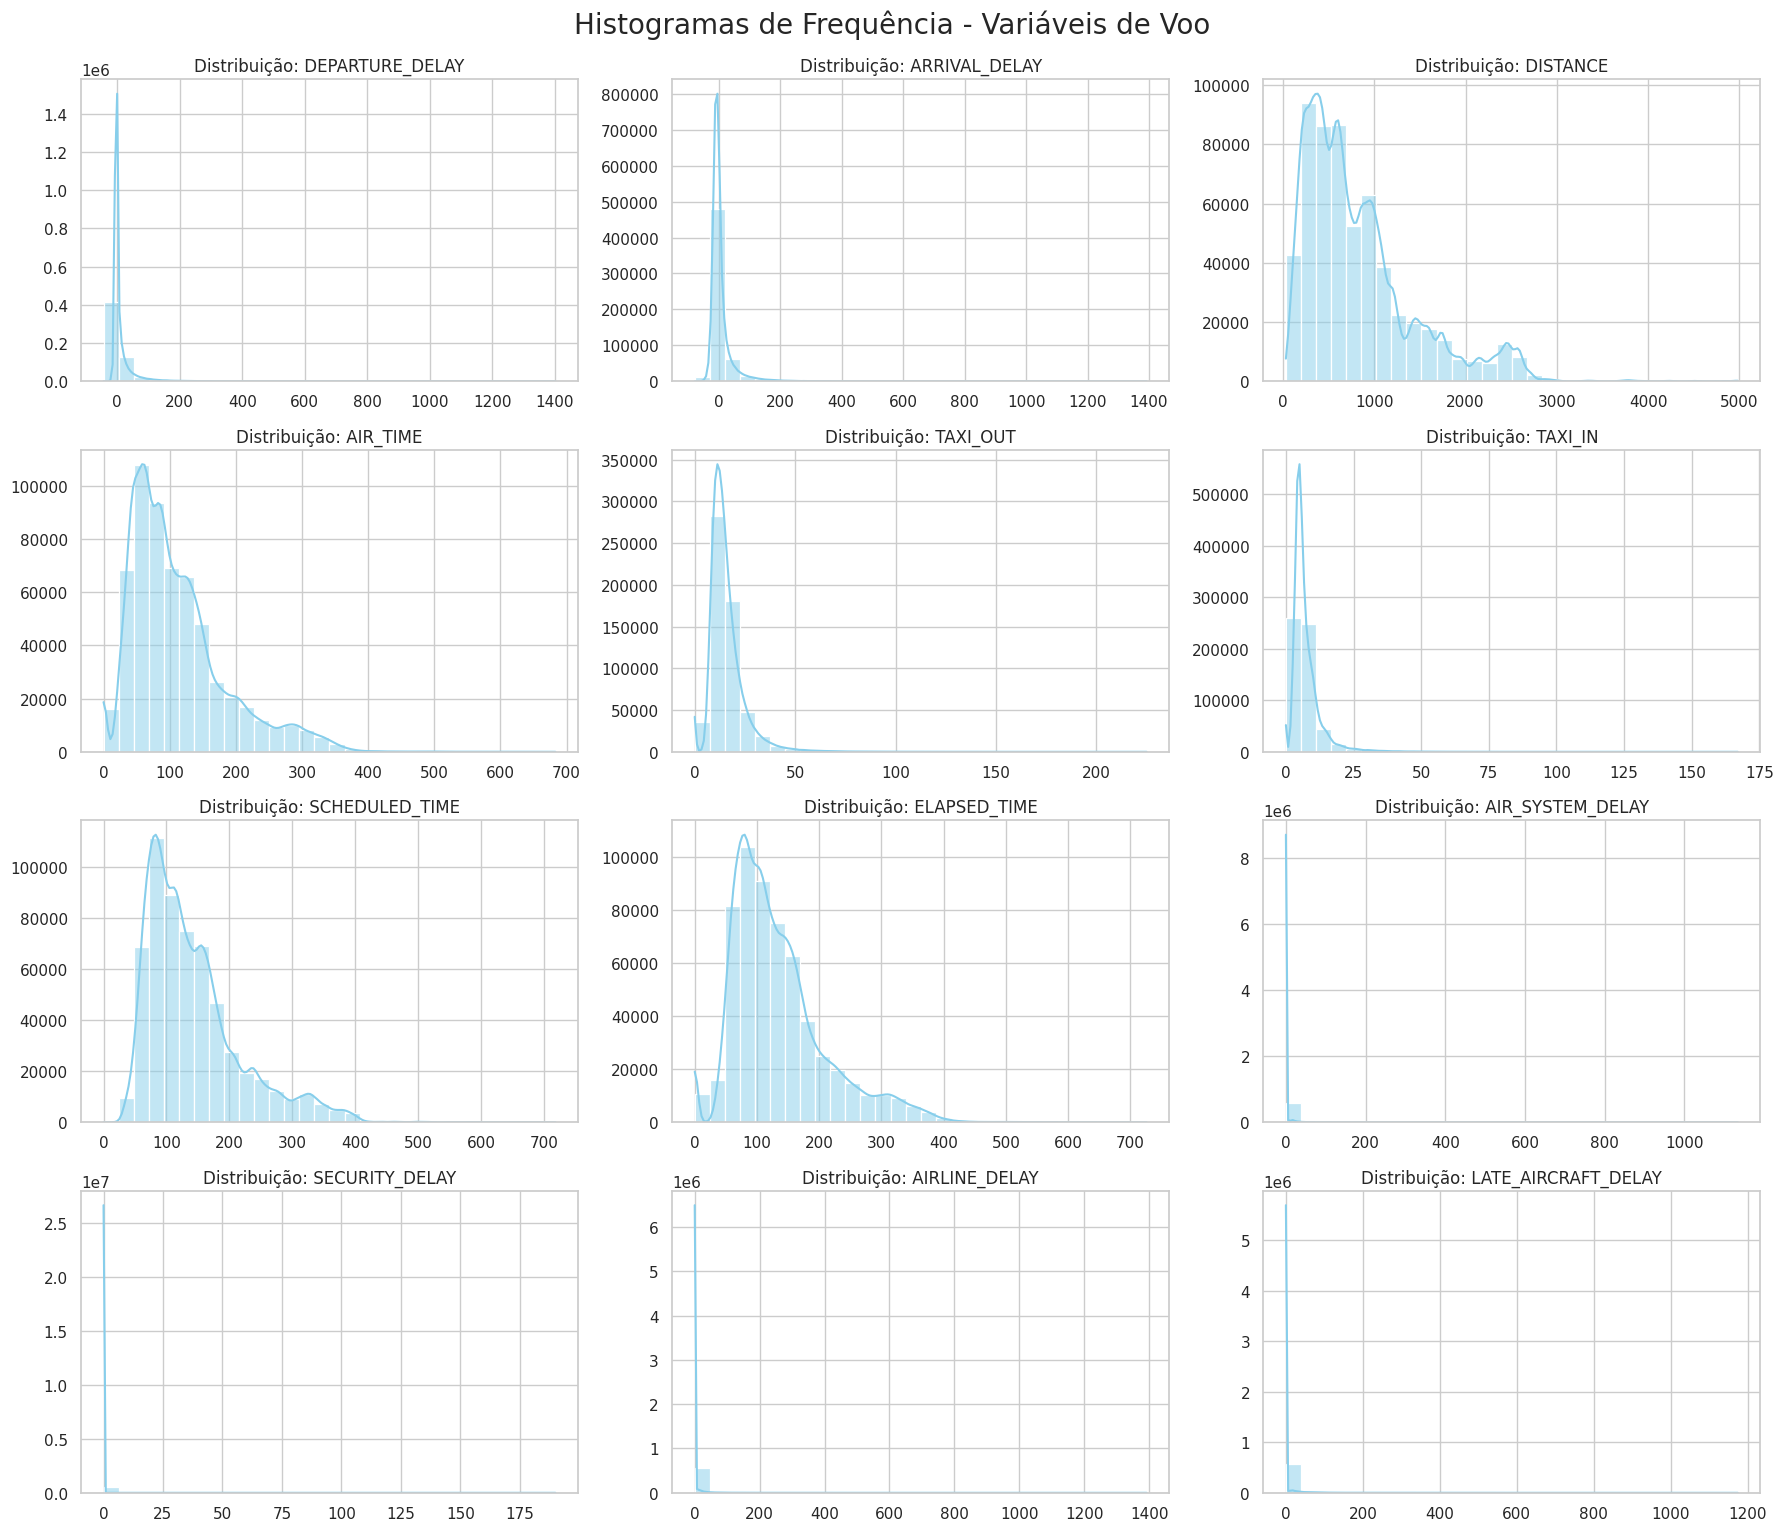

In [7]:
# Selecionando colunas numéricas de interesse para estatística
cols_num = [
    'DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'DISTANCE', 'AIR_TIME', 
    'TAXI_OUT', 'TAXI_IN', 'SCHEDULED_TIME', 'ELAPSED_TIME',
    'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 
    'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'
]

# Convertendo uma amostra para Pandas (amostra de 50.000 linhas para performance)
pdf = df_resultado.select(cols_num).sample(False, 0.1, seed=42).toPandas()

# Garantindo que os dados sejam numéricos e tratando NaNs (preenchendo com 0 para os delays)
pdf = pdf.apply(pd.to_numeric, errors='coerce').fillna(0)

plt.figure(figsize=(16, 10))
sns.set_theme(style="whitegrid")

# Criando o gráfico
ax = sns.boxplot(data=pdf, orient="h", palette="Set2")
plt.title("Distribuição Estatística dos Campos Numéricos (Boxplot)", fontsize=16)
plt.xlabel("Minutos / Milhas")
plt.show()

# Configuramos uma grade de subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(cols_num[:12]): # Limitando aos 12 principais
    sns.histplot(pdf[col], bins=30, ax=axes[i], kde=True, color='skyblue')
    axes[i].set_title(f'Distribuição: {col}', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.suptitle("Histogramas de Frequência - Variáveis de Voo", fontsize=20, y=1.02)
plt.show()

No primeiro gráfico (boxplot) acima temos que:

1️⃣ Atrasos de chegada e saída

🔹 DEPARTURE_DELAY e ARRIVAL_DELAY

- A mediana está muito próxima de zero, indicando que a maior parte dos voos não sofre atrasos relevantes.
- Há forte assimetria à direita: poucos casos concentram atrasos muito altos.
- Presença de muitos outliers extremos → voos com atrasos muito grandes (eventos raros, mas impactantes).
- Isso sugere:
- A média pode ser distorcida.
- Medidas robustas (mediana, IQR) são mais adequadas.

2️⃣ Distância e tempo de voo

DISTANCE, AIR_TIME, ELAPSED_TIME, SCHEDULED_TIME

🔹 DISTANCE

- Alta variabilidade: de voos curtos a rotas muito longas.
- Forte cauda à direita, com outliers acima de 4000–5000 milhas.
- Distribuição típica de malha aérea: muitos voos curtos/médios e poucos muito longos.

🔹 AIR_TIME, ELAPSED_TIME, SCHEDULED_TIME

- Distribuições mais concentradas, mas ainda com outliers de voos muito longos.
- ELAPSED_TIME e SCHEDULED_TIME mostram dispersão semelhante → indica consistência entre planejamento e execução.
- A presença de outliers pode estar ligada a:
- Voos internacionais
- Conexões longas em solo
- Atrasos severos

3️⃣ Tempo em solo

- TAXI_OUT e TAXI_IN
- A maior parte dos valores é baixa e concentrada.
- Alguns outliers moderados:
- Podem indicar congestionamento em aeroportos grandes.
- Situações de clima ruim ou tráfego intenso.
- Em geral, impacto menor no atraso total, mas ainda relevante operacionalmente.

4️⃣ Componentes de atraso (causas)

AIR_SYSTEM_DELAY, SECURITY_DELAY, AIRLINE_DELAY, LATE_AIRCRAFT_DELAY, WEATHER_DELAY

- Predominância de valores zero ou muito próximos de zero:
- A maioria dos voos não sofre atrasos por esses fatores.
- Caudas longas e vários outliers:
- Indicam eventos raros, porém severos.

No segundo gráfico (pairplot) temos que:

1️⃣ Atrasos de partida e chegada
DEPARTURE_DELAY e ARRIVAL_DELAY

Padrão observado:

- Pico extremamente concentrado em torno de 0 minutos.
- Cauda longa à direita (right-skewed).
- Frequência cai rapidamente conforme o atraso aumenta.
Interpretação:

- A maioria dos voos sai e chega no horário ou com atraso muito pequeno.
- Um pequeno subconjunto apresenta atrasos severos (centenas ou até milhares de minutos), mas com baixa frequência.
- Distribuição não normal → assimetria forte.

Implicações:

- Média não é representativa.

2️⃣ Distância e duração do voo
DISTANCE

Padrão observado:
Distribuição multimodal:

- Um grande pico em distâncias curtas/médias (voos regionais/domésticos).
- Menores picos em distâncias maiores.
- Cauda longa até ~5000 milhas.

Interpretação:

- Reflete a malha aérea:
- Muitos voos curtos e médios.
- Poucos voos de longa distância.

AIR_TIME, SCHEDULED_TIME, ELAPSED_TIME

Padrão comum:

- Assimetria à direita.
- Pico principal em tempos entre 50–150 minutos.
- Cauda longa para voos mais longos.

Diferenças:

- SCHEDULED_TIME → distribuição mais “limpa” (planejada).
- ELAPSED_TIME → mais dispersão (efeito de atrasos, taxi, espera).
- AIR_TIME → reflete mais diretamente a distância.

Interpretação:

- Boa coerência entre planejamento e execução, mas:
- A cauda longa em ELAPSED_TIME evidencia impacto de atrasos operacionais.

3️⃣ Tempos de taxi
TAXI_OUT e TAXI_IN

Padrão observado:

Distribuições altamente concentradas em valores baixos:

- TAXI_OUT: geralmente < 30 min.
- TAXI_IN: geralmente < 20 min.
- Poucos casos extremos.

Interpretação:

- A maior parte dos aeroportos opera com tempos de taxi eficientes.

Os outliers provavelmente refletem:

- Congestionamento
- Clima
- Grandes hubs

Importância:

Impacto marginal na maioria dos voos, mas:

- Pode ser relevante em aeroportos específicos.

4️⃣ Componentes de atraso (causas)
AIR_SYSTEM_DELAY, SECURITY_DELAY, AIRLINE_DELAY, LATE_AIRCRAFT_DELAY, WEATHER_DELAY

Padrão dominante:

- Enorme concentração em zero.
- Pequena fração dos registros com valores > 0.
- Quando ocorrem, alguns casos atingem valores elevados.

Interpretação:

- A maioria dos voos não sofre atraso por essas causas.
- Os atrasos são eventos esparsos e episódicos, mas potencialmente graves.

Destaques:

AIRLINE_DELAY e LATE_AIRCRAFT_DELAY:
- Distribuições mais “espalhadas”.
- Indicam que problemas operacionais internos são causas frequentes de atrasos relevantes.

WEATHER_DELAY:

- Menos comum, mas com cauda longa → quando ocorre, o impacto é grande.

SECURITY_DELAY:

- Extremamente raro e concentrado em zero → impacto baixo na maioria dos casos.

### 3. Selecionar features para o classificador

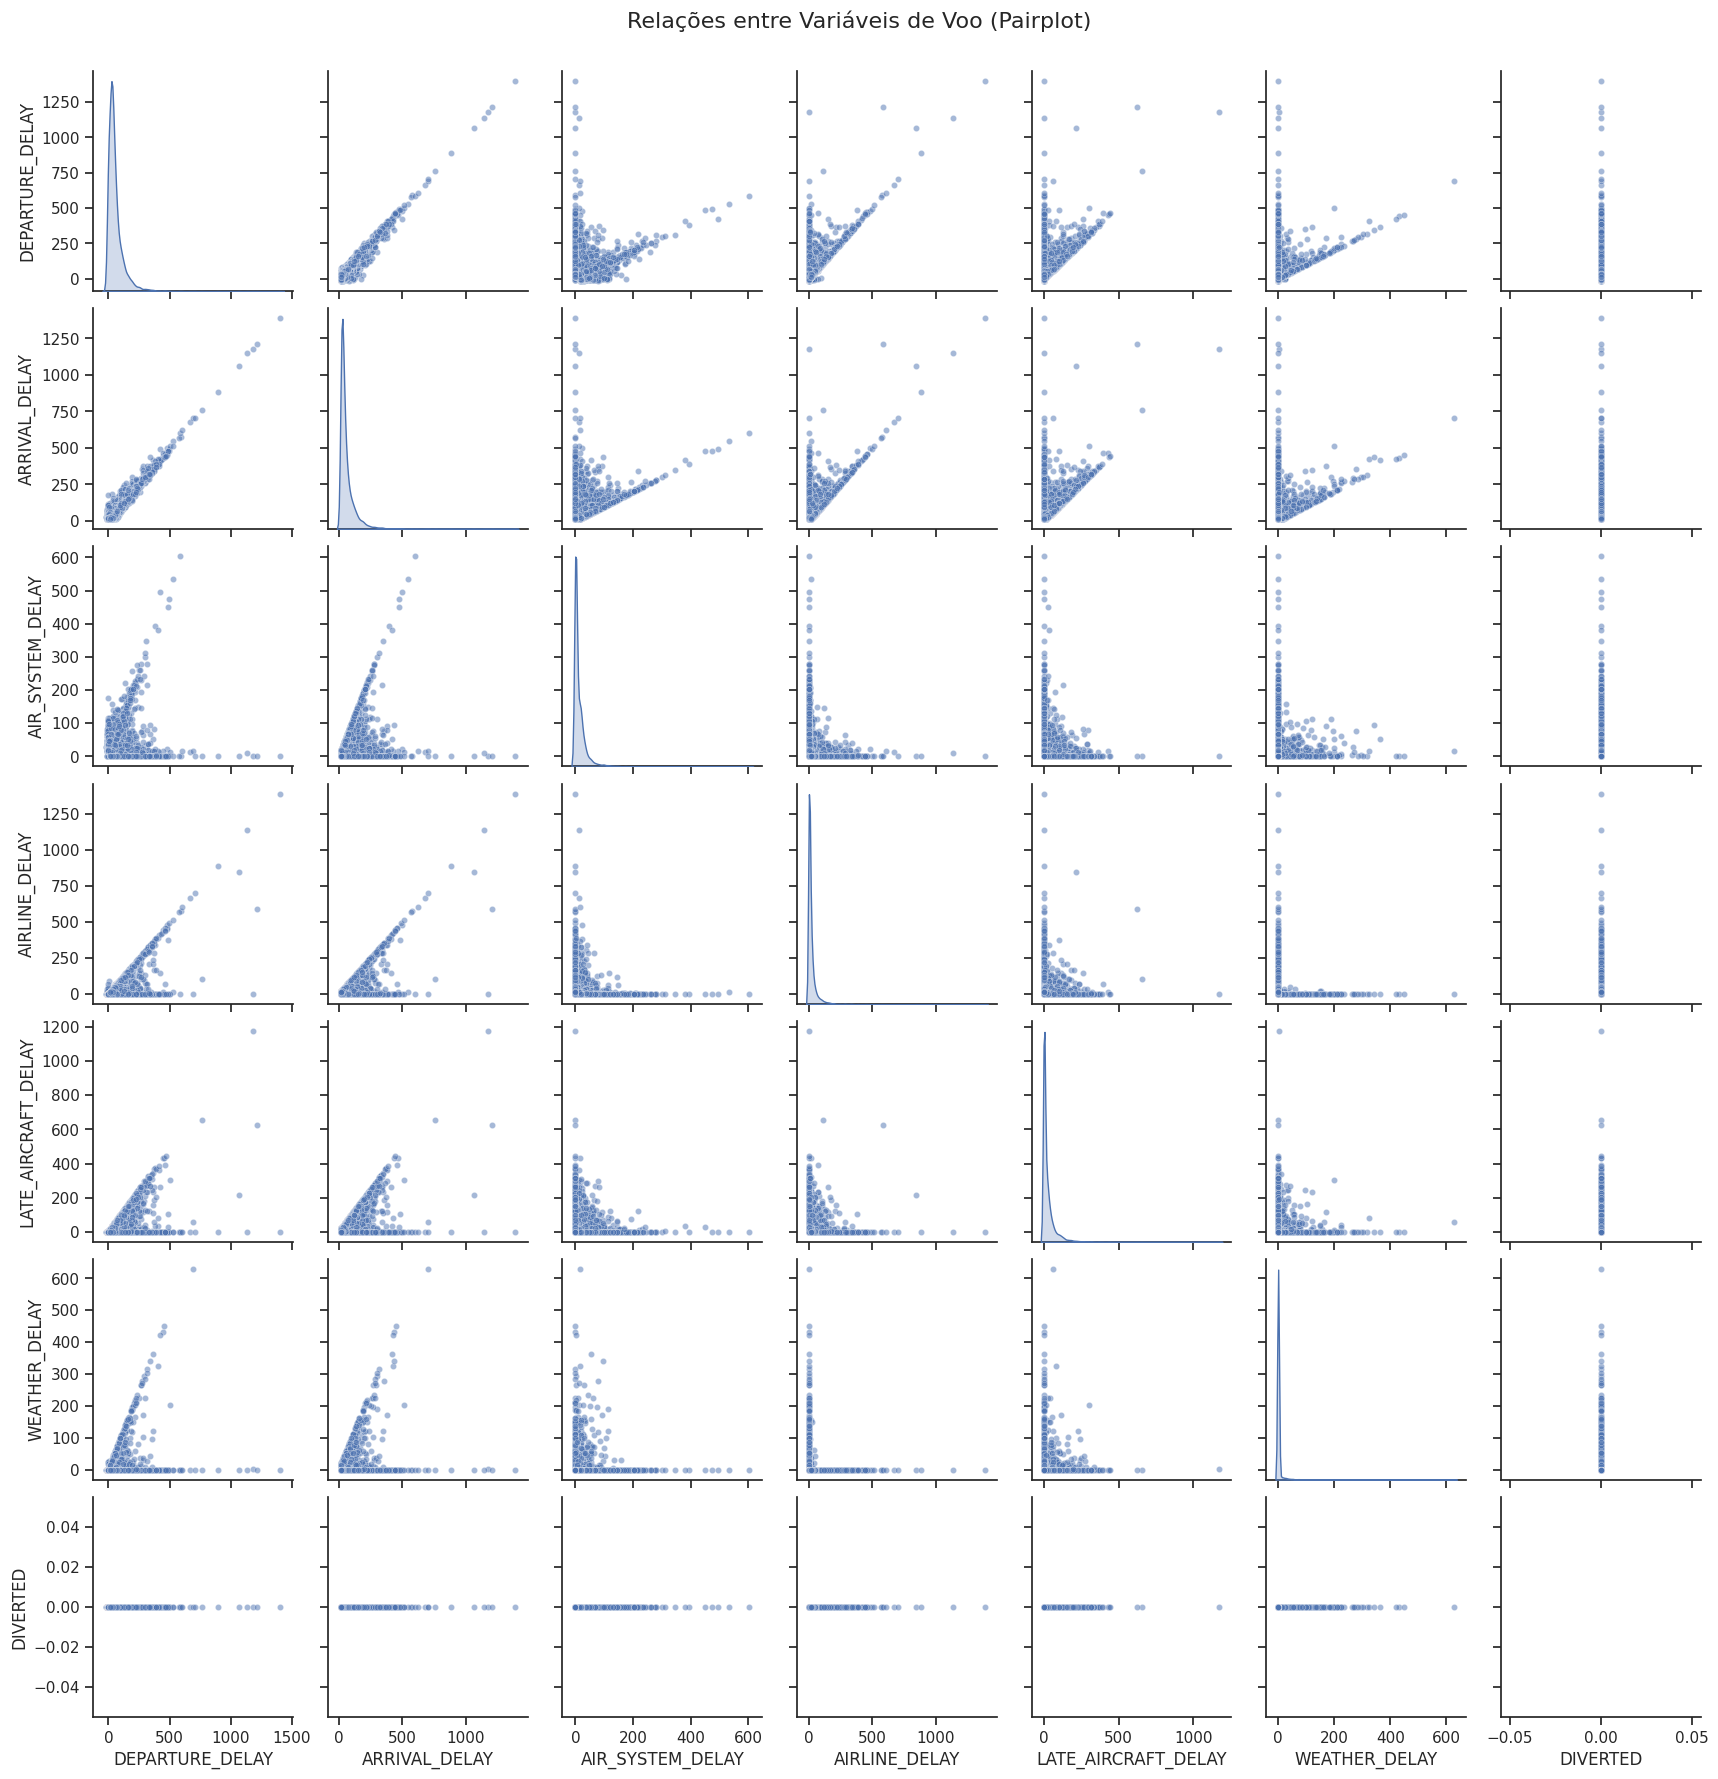

In [8]:
cols_pairplot = [
    'DEPARTURE_DELAY',
    'ARRIVAL_DELAY',
    'AIR_SYSTEM_DELAY',
    'AIRLINE_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'WEATHER_DELAY',
    'DIVERTED'
]

pdf_sample = df_resultado.select(cols_pairplot).sample(False, 0.01, seed=42).toPandas()

pdf_sample = pdf_sample.dropna()

sns.set_theme(style="ticks")
g = sns.pairplot(
    pdf_sample, 
    diag_kind="kde",
    plot_kws={'alpha':0.5, 's': 20}
)

g.fig.suptitle("Relações entre Variáveis de Voo (Pairplot)", y=1.02, fontsize=16)
plt.show()

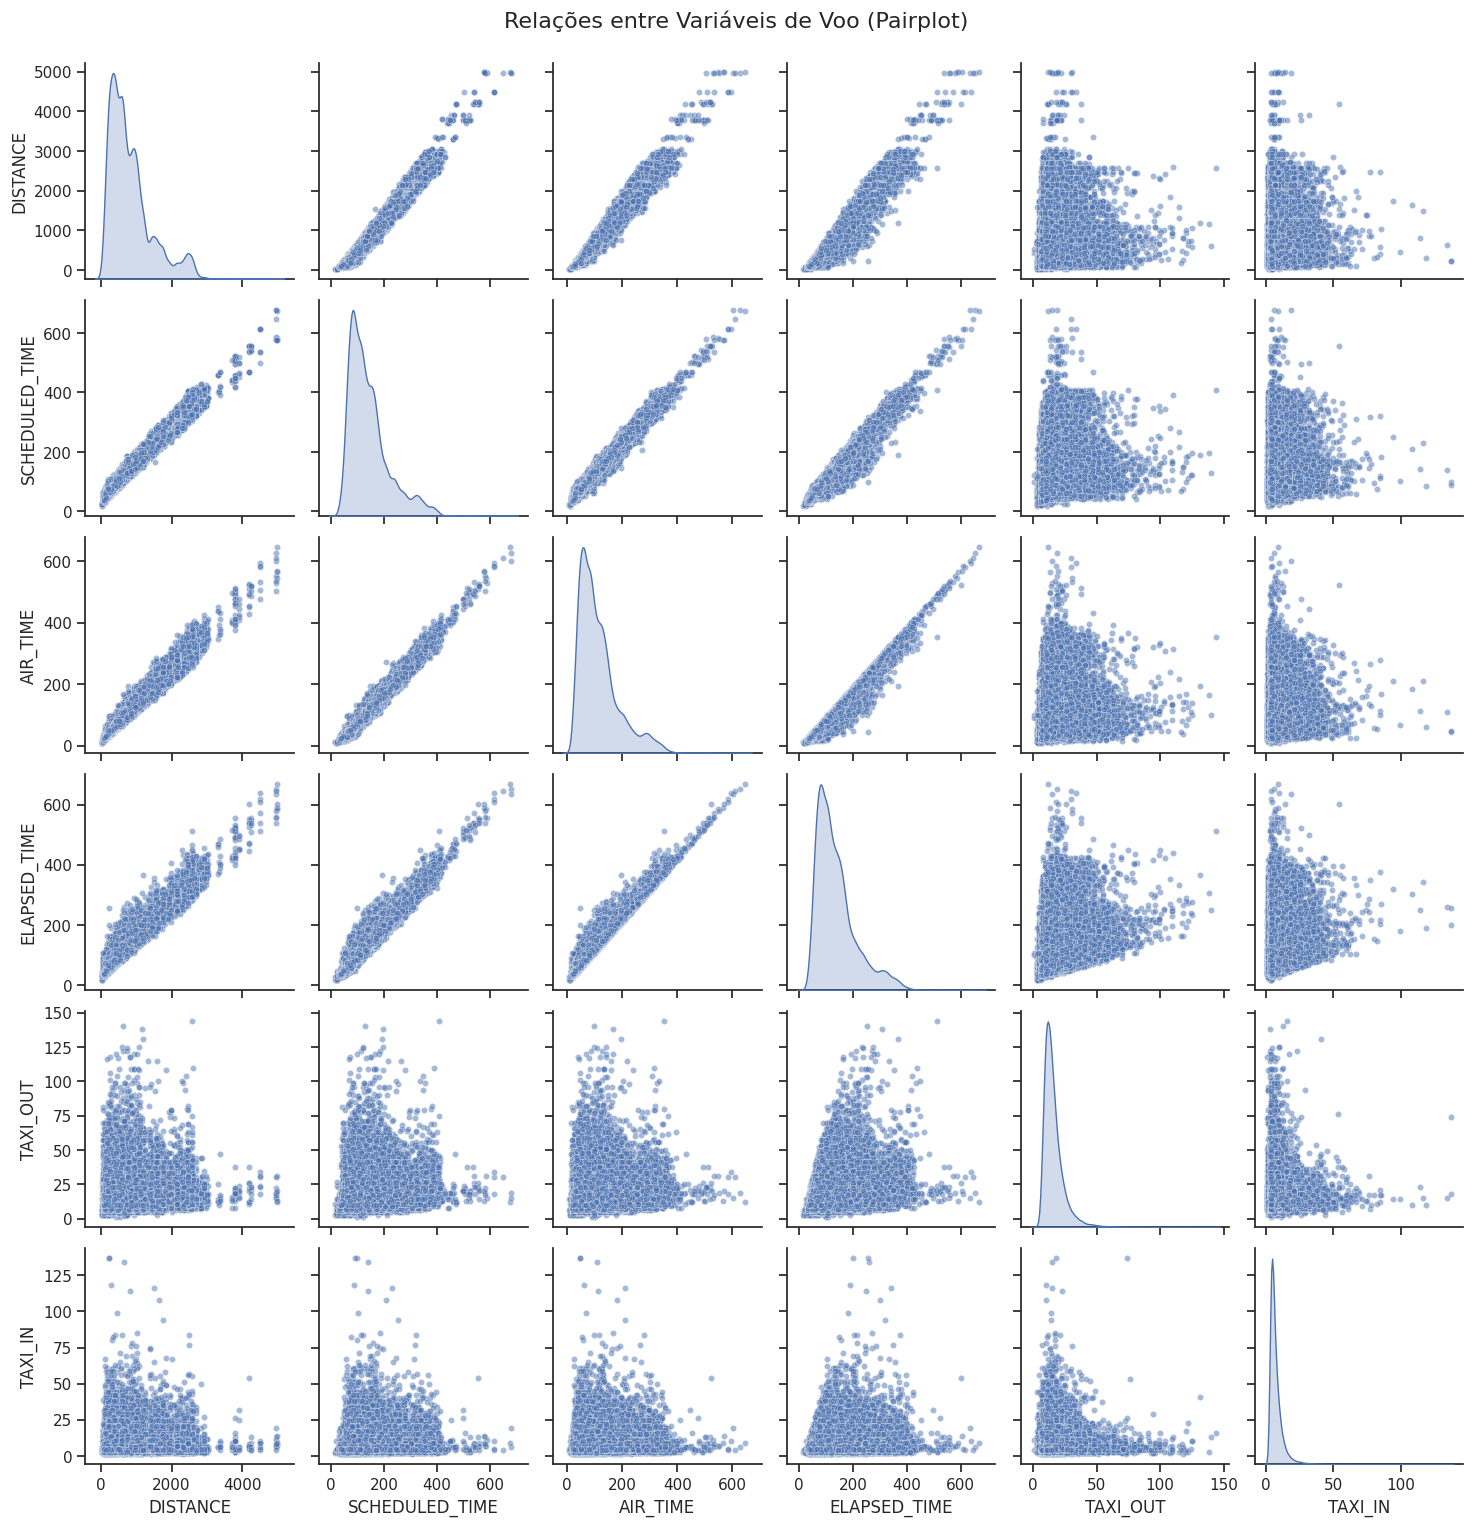

In [9]:
cols_pairplot = [
    'DISTANCE',
    'SCHEDULED_TIME',
    'AIR_TIME',
    'ELAPSED_TIME',
    'TAXI_OUT',
    'TAXI_IN'
]

pdf_sample = df_resultado.select(cols_pairplot).sample(False, 0.01, seed=42).toPandas()

pdf_sample = pdf_sample.dropna()

sns.set_theme(style="ticks")
g = sns.pairplot(
    pdf_sample, 
    diag_kind="kde",
    plot_kws={'alpha':0.5, 's': 20}
)

g.fig.suptitle("Relações entre Variáveis de Voo (Pairplot)", y=1.02, fontsize=16)
plt.show()

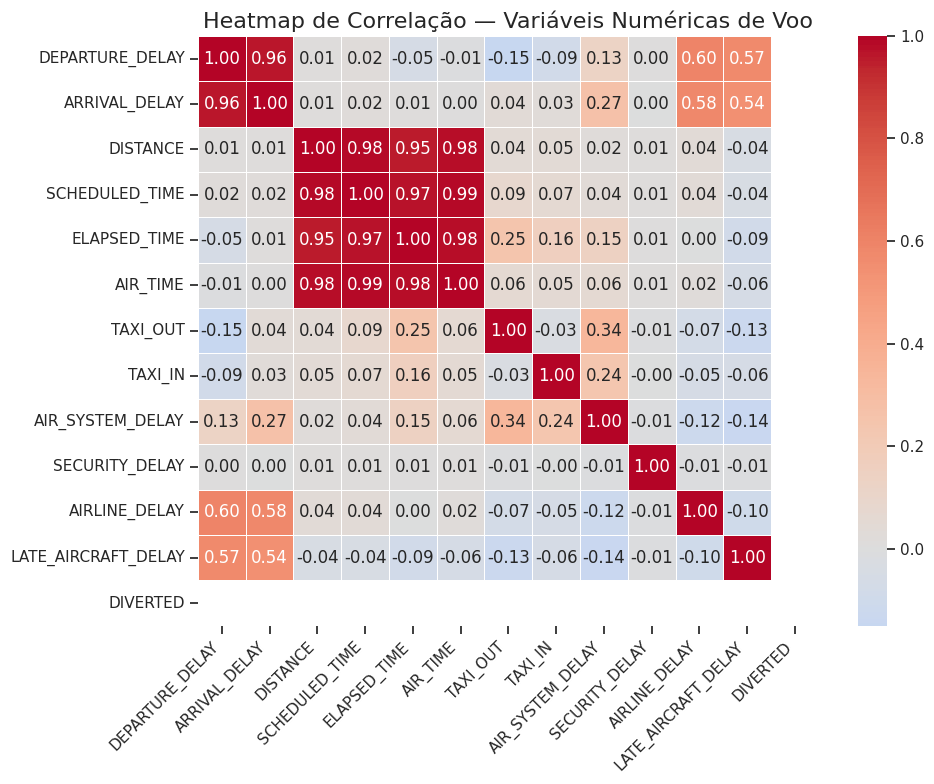

In [10]:
cols_numericas = [
    'DEPARTURE_DELAY', 
    'ARRIVAL_DELAY',
    'DISTANCE',
    'SCHEDULED_TIME',
    'ELAPSED_TIME',
    'AIR_TIME',
    'TAXI_OUT',
    'TAXI_IN',
    'AIR_SYSTEM_DELAY',
    'SECURITY_DELAY',
    'AIRLINE_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'DIVERTED'
]

pdf_corr = (
    df_resultado
    .select(cols_numericas)
    .sample(False, 0.02, seed=42)  # 2%
    .toPandas()
)

pdf_corr = pdf_corr.dropna()

corr_matrix = pdf_corr.corr(method='pearson')

plt.figure(figsize=(10, 8))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)

plt.title("Heatmap de Correlação — Variáveis Numéricas de Voo", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

**Feature	Correlação**
- DEPARTURE_DELAY	0.96 
- AIRLINE_DELAY	0.58
- LATE_AIRCRAFT_DELAY	0.54
- AIR_SYSTEM_DELAY	0.27
- WEATHER_DELAY	0.27
- SECURITY_DELAY	~0.00

FEATURE SET FINAL — PRÉ-VOO (sem vazamento)

Usável antes do avião sair do gate

Features selecionadas: 

- ORIGIN_AIRPORT
- DESTINATION_AIRPORT
- AIRLINE
- ORIGIN_CITY

**Justificativa:**

Baseado no pairplot: distância explica tempo

Temporalidade ajuda a capturar sazonalidade

Aeroporto e companhia capturam congestionamento estrutural

    ----------------------------------------------

FEATURE SET FINAL — PÓS-VOO (ou pós-partida)

Alta performance, modelo explicativo

FEATURES SELECIONADAS:

- DISTANCE
- SCHEDULED_TIME
- MONTH
- DAY_OF_WEEK
- ELAPSED_TIME
- DEPARTURE_DELAY

**Justificativa**

Confirmado pelo heatmap + pairplot

Baixa multicolinearidade

Forte poder explicativo

    --------------------------

### 4. Modelo de classificação

In [18]:
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F
from pyspark.ml.stat import KolmogorovSmirnovTest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.functions import vector_to_array

**IMPORTANTE**

       - Será considerado somente atraso tudo que tiver com tempo de delay > 30

In [12]:
df = df_resultado

df = df.withColumn(
    "DELAYED",
    (F.col("ARRIVAL_DELAY") > 30).cast("double") #REGRA -> TUDO QUE FOR MENOR QUE 30 SERÁ CONSIDERADO ATRASO
)

num_features = [
    'DISTANCE',
    'SCHEDULED_TIME',
    'MONTH',
    'DAY_OF_WEEK',
    'ELAPSED_TIME',
    'DEPARTURE_DELAY',
    'DIVERTED'
]

cat_features = [
    'ORIGIN_AIRPORT',
    'DESTINATION_AIRPORT',
    'AIRLINE',
    'ORIGIN_CITY'
]

df = df.dropna(subset=num_features + cat_features + ['DELAYED'])

In [13]:
indexers = [
    StringIndexer(
        inputCol=c,
        outputCol=f"{c}_idx",
        handleInvalid="skip"
    ) for c in cat_features
]

encoders = [
    OneHotEncoder(
        inputCol=f"{c}_idx",
        outputCol=f"{c}_oh"
    ) for c in cat_features
]

assembler = VectorAssembler(
    inputCols=num_features + [f"{c}_oh" for c in cat_features],
    outputCol="features"
)

rf = RandomForestClassifier(
    labelCol="DELAYED",
    featuresCol="features",
    numTrees=200,   # ↓
    maxDepth=14,     # ↓
    seed=42
)

pipeline = Pipeline(
    stages=indexers + encoders + [assembler, rf]
)

### 5. Construção de sample

Objetivo é diminuir o tempo de execução do modelo RandomFlorest:
    Para isso vamos utilizar de estatística descriva para fazer a validação da amostra.

In [14]:
total_sample = 100_000

counts = df.groupBy("DELAYED").count()
counts.show()

counts_pd = counts.toPandas()
fractions = {
    row['DELAYED']: (total_sample * row['count'] / df.count()) / row['count']
    for _, row in counts_pd.iterrows()
}

df_sample = df.sampleBy(
    col="DELAYED",
    fractions=fractions,
    seed=42
)

df_sample.count()
df_sample.groupBy("DELAYED").count().show()

# 🔹 3.1 Estatísticas descritivas
print("Estatísticas - Dataset Completo:")
df.select(num_features).describe().show()

print("Estatísticas - Amostra:")
df_sample.select(num_features).describe().show()

# 🔹 3.2 Teste Kolmogorov-Smirnov (distribuições)
for col in num_features:
    print(f"Teste KS para: {col}")
    KolmogorovSmirnovTest.test(df_sample, col, "norm").show()

+-------+-------+
|DELAYED|  count|
+-------+-------+
|    0.0|4630807|
|    1.0| 600323|
+-------+-------+



+-------+-----+
|DELAYED|count|
+-------+-----+
|    0.0|88831|
|    1.0|11570|
+-------+-----+

Estatísticas - Dataset Completo:


+-------+-----------------+------------------+-----------------+------------------+------------------+-----------------+--------+
|summary|         DISTANCE|    SCHEDULED_TIME|            MONTH|       DAY_OF_WEEK|      ELAPSED_TIME|  DEPARTURE_DELAY|DIVERTED|
+-------+-----------------+------------------+-----------------+------------------+------------------+-----------------+--------+
|  count|          5231130|           5231130|          5231130|           5231130|           5231130|          5231130| 5231130|
|   mean|825.1290747888123|142.00454184851074|6.229131755471571| 3.925629835236364|137.19396401924632|9.696480492742486|     0.0|
| stddev| 608.730661449527| 75.36161750918106|3.377319268466929|1.9903897370391932|  74.3007565372224|37.39590830058856|     0.0|
|    min|               31|                18|                1|                 1|                14|              -82|       0|
|    max|             4983|               718|               12|                 7|       

+-------+-----------------+------------------+-----------------+------------------+------------------+------------------+--------+
|summary|         DISTANCE|    SCHEDULED_TIME|            MONTH|       DAY_OF_WEEK|      ELAPSED_TIME|   DEPARTURE_DELAY|DIVERTED|
+-------+-----------------+------------------+-----------------+------------------+------------------+------------------+--------+
|  count|           100401|            100401|           100401|            100401|            100401|            100401|  100401|
|   mean|826.0570412645293|142.16114381330863|6.226750729574406|3.9252298283881633|137.38268543142001| 9.764683618689057|     0.0|
| stddev|608.8521282437791| 75.45991850868312|3.386838529955785|1.9868334040165103| 74.46995533510876|38.205156565560024|     0.0|
|    min|               31|                20|                1|                 1|                18|               -33|       0|
|    max|             4983|               680|               12|                 7|

+------+---------+
|pValue|statistic|
+------+---------+
|   0.0|      1.0|
+------+---------+

Teste KS para: SCHEDULED_TIME


+------+---------+
|pValue|statistic|
+------+---------+
|   0.0|      1.0|
+------+---------+

Teste KS para: MONTH


+--------------------+------------------+
|              pValue|         statistic|
+--------------------+------------------+
|1.319344189454341...|0.8893025368499403|
+--------------------+------------------+

Teste KS para: DAY_OF_WEEK


+--------------------+-----------------+
|              pValue|        statistic|
+--------------------+-----------------+
|1.287149276052446...|0.841344746068543|
+--------------------+-----------------+

Teste KS para: ELAPSED_TIME


+------+---------+
|pValue|statistic|
+------+---------+
|   0.0|      1.0|
+------+---------+

Teste KS para: DEPARTURE_DELAY


+--------------------+-----------------+
|              pValue|        statistic|
+--------------------+-----------------+
|6.903451144069095...|0.475790719238562|
+--------------------+-----------------+

Teste KS para: DIVERTED


+--------------------+---------+
|              pValue|statistic|
+--------------------+---------+
|6.957021625453308...|      0.5|
+--------------------+---------+



### 6. Treinando o modelo

In [15]:
train_df, test_df = df_sample.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_df)
preds = model.transform(test_df)

26/01/08 15:32:25 WARN DAGScheduler: Broadcasting large task binary with size 1045.7 KiB
26/01/08 15:32:28 WARN DAGScheduler: Broadcasting large task binary with size 1381.1 KiB
26/01/08 15:32:33 WARN DAGScheduler: Broadcasting large task binary with size 1798.8 KiB
26/01/08 15:32:39 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
26/01/08 15:32:46 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
26/01/08 15:32:58 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
26/01/08 15:33:09 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
26/01/08 15:33:26 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
26/01/08 15:33:50 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
26/01/08 15:34:12 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


### 7. Métricas de eficácia

In [ ]:
# ROC e PR
roc = BinaryClassificationEvaluator(
    labelCol="DELAYED",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
).evaluate(preds)

pr = BinaryClassificationEvaluator(
    labelCol="DELAYED",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderPR"
).evaluate(preds)

# Accuracy
acc = MulticlassClassificationEvaluator(
    labelCol="DELAYED",
    predictionCol="prediction",
    metricName="accuracy"
).evaluate(preds)

print(f"""
ROC-AUC : {roc:.3f}
PR-AUC  : {pr:.3f}
Accuracy: {acc:.3f}
""")


26/01/08 15:34:38 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
26/01/08 15:34:54 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
26/01/08 15:35:03 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB



ROC-AUC : 0.958
PR-AUC  : 0.872
Accuracy: 0.886



26/01/08 15:36:15 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


ROC-AUC (Spark): 0.9585


26/01/08 15:36:24 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


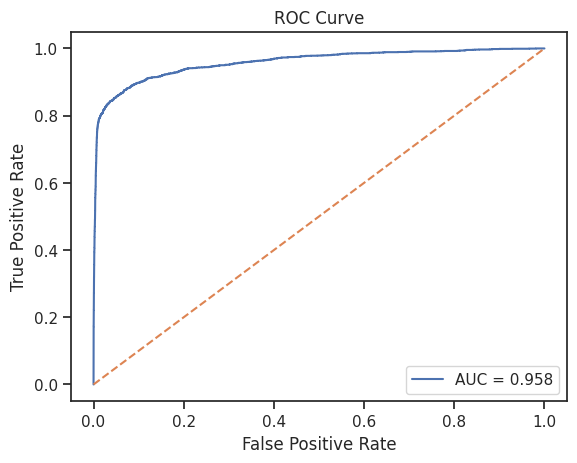

In [19]:
evaluator = BinaryClassificationEvaluator(
    labelCol="DELAYED",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

roc_auc = evaluator.evaluate(preds)
print(f"ROC-AUC (Spark): {roc_auc:.4f}")


preds_roc = preds.select(
    F.col("DELAYED").cast("double").alias("label"),
    vector_to_array("probability")[1].alias("score")   # prob da classe 1
)

pdf = preds_roc.toPandas()

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(pdf["label"], pdf["score"])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Modelagem Não Supervisionada 

## Abordagem com o algoritmo DBSCAN

1. Definir objetivo
2. Selecionar features numéricas
3. Limpeza e tratamento
3.1. Criar sample dos dados
3.2. Teste do sample com estatística
4. Escalonamento (StandardScaler)
5. PCA
6. Escolher eps e min_samples
7. Treinar DBSCAN
8. Interpretar resultados no negócio
9. Discuta as limitações dos modelos
10. Proponha melhorias e próximos passos

### Bibliotecas

In [21]:
#Librarys
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
from pyspark.ml.functions import vector_to_array
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from pyspark.sql.functions import monotonically_increasing_id

### 1. Definir objetivo:

Exemplos do que podemos analisar:

-    “Quais voos têm comportamento anormal?”

-    “Existem padrões de atraso por tipo de voo?”

-    “Quais combinações de rota + tempo + atraso fogem do padrão?”

### 2. Selecionar features numéricas

Numéricas:

        DISTANCE
        SCHEDULED_TIME
        ELAPSED_TIME
        AIR_TIME
        TAXI_OUT
        TAXI_IN
        DEPARTURE_DELAY
        ARRIVAL_DELAY
        DIVERTED
        CANCELLED

Categóricas:

        AIRLINE
        ORIGIN_AIRPORT
        DESTINATION_AIRPORT
        ORIGIN_CITY
        DEST_CITY


### 3. Limpeza e tratamento

In [22]:
cols_remover = [
    "CANCELLATION_REASON",
    "AIR_SYSTEM_DELAY",
    "SECURITY_DELAY",
    "AIRLINE_DELAY",
    "LATE_AIRCRAFT_DELAY",
    "WEATHER_DELAY"
]

df_reduzido = df_resultado.drop(*cols_remover)
df_clean = df_reduzido.dropna()

total = df_clean.count()

null_percent = df_clean.select([
    (F.count(F.when(F.col(c).isNull(), c)) / F.lit(total) * 100).alias(c)
    for c in df_clean.columns
])

null_percent.show(truncate=False)


print("Total original :", df_resultado.count())
print("Após remover colunas:", df_reduzido.count())
print("Após dropna:", df_clean.count())

perda = 1 - (df_clean.count() / df_reduzido.count())
print("Percentual de perda após a limpeza:", f"{perda*100:.2f}%")

+----+-----+---+-----------+-------+------------+-------------+-----------+--------------+-------------------+-----------+------------+--------------+---------------+----------------+-------------------+------------------------+---------+----------+------------+-------------+--------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|AIRLINE_NAME|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|ORIGIN_AIRPORT_NAME|ORIGIN_CITY|ORIGIN_STATE|ORIGIN_COUNTRY|ORIGIN_LATITUDE|ORIGIN_LONGITUDE|DESTINATION_AIRPORT|DESTINATION_AIRPORT_NAME|DEST_CITY|DEST_STATE|DEST_COUNTRY|DEST_LATITUDE|DEST_LONGITUDE|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|
+----+-----+---+--

Total original : 5819079


Após remover colunas: 5819079


Após dropna: 5222000


Percentual de perda após a limpeza: 10.26%


### 3.1. Criar sample dos dados

In [23]:
target_size = 100_000

total_rows = df_clean.count()

fraction = target_size / total_rows

print(f"Total de linhas: {total_rows}")
print(f"Fração de amostragem: {fraction:.6f}")

df_sample = df_clean.sample(
    withReplacement=False,
    fraction=fraction,
    seed=42
)

Total de linhas: 5222000
Fração de amostragem: 0.019150


### 3.2. Teste do sample com estatística

In [24]:
print("Tamanho da amostra:", df_sample.count())

print("Dataset completo:")
df_clean.select("DISTANCE", "SCHEDULED_TIME","ELAPSED_TIME","AIR_TIME","TAXI_OUT","TAXI_IN","DEPARTURE_DELAY","ARRIVAL_DELAY","DIVERTED","CANCELLED").describe().show()

print("Amostra:")
df_sample.select("DISTANCE", "SCHEDULED_TIME","ELAPSED_TIME","AIR_TIME","TAXI_OUT","TAXI_IN","DEPARTURE_DELAY","ARRIVAL_DELAY","DIVERTED","CANCELLED").describe().show()

Tamanho da amostra: 100376
Dataset completo:


+-------+-----------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+--------+---------+
|summary|         DISTANCE|    SCHEDULED_TIME|      ELAPSED_TIME|          AIR_TIME|         TAXI_OUT|          TAXI_IN|  DEPARTURE_DELAY|    ARRIVAL_DELAY|DIVERTED|CANCELLED|
+-------+-----------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+--------+---------+
|  count|          5222000|           5222000|           5222000|           5222000|          5222000|          5222000|          5222000|          5222000| 5222000|  5222000|
|   mean|825.7541681348142|142.08729356568364|137.27728513979318|113.74186307927997|16.10082439678284|7.434597663730371|9.700098621217924|4.890090578322482|     0.0|      0.0|
| stddev|608.9702831255355| 75.38905222462462|  74.3254519293418| 72.32389547754757|8.978904583119986| 5.66830871673706|

+-------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+--------+---------+
|summary|         DISTANCE|   SCHEDULED_TIME|      ELAPSED_TIME|          AIR_TIME|         TAXI_OUT|          TAXI_IN|   DEPARTURE_DELAY|     ARRIVAL_DELAY|DIVERTED|CANCELLED|
+-------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+--------+---------+
|  count|           100376|           100376|            100376|            100376|           100376|           100376|            100376|            100376|  100376|   100376|
|   mean|828.1313062883557|142.3785167769188|137.53177054275923|114.04985255439547|16.06949868494461|7.412419303419144| 9.588855901809197| 4.742109667649637|     0.0|      0.0|
| stddev|609.0436512922602|75.56438153816987| 74.54559120068353| 72.53586094935687| 8.78092417752512| 5.64467509626

### 4. Escalonamento (StandardScaler)

In [25]:
num_features = [
    "DISTANCE", 
    "SCHEDULED_TIME",
    "ELAPSED_TIME",
    "AIR_TIME",
    "TAXI_OUT",
    "TAXI_IN",
    "DEPARTURE_DELAY",
    "ARRIVAL_DELAY",
    "DIVERTED",
    "CANCELLED"
]

In [26]:
assembler = VectorAssembler(
    inputCols=num_features,
    outputCol="features"
)

df_vec = assembler.transform(df_sample)

In [27]:
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(df_vec)
df_scaled = scaler_model.transform(df_vec)

### 5. PCA

In [28]:
pca = PCA(
    k=3,   # número de componentes
    inputCol="scaled_features",
    outputCol="pca_features"
)

pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)

26/01/08 15:40:00 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
26/01/08 15:40:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


### 6. Escolher eps e min_samples

In [29]:
pdf = (
    df_pca
    .select(vector_to_array("pca_features").alias("features"))
    .toPandas()
)

X = pdf["features"].tolist()


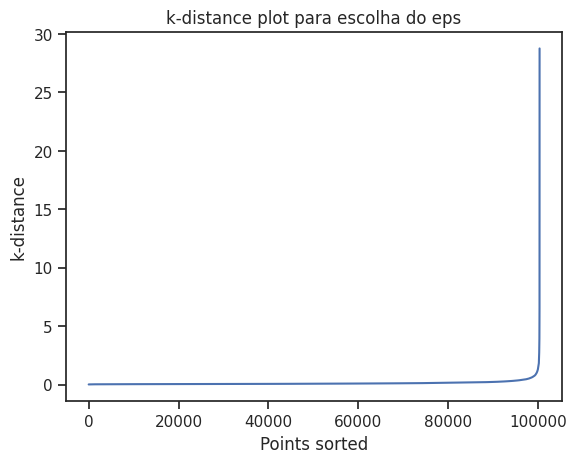

In [30]:
k = 10   # mesmo valor de min_samples
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, _ = nbrs.kneighbors(X)

# Ordena distâncias do k-ésimo vizinho
distances = np.sort(distances[:, k-1])

plt.figure()
plt.plot(distances)
plt.ylabel("k-distance")
plt.xlabel("Points sorted")
plt.title("k-distance plot para escolha do eps")
plt.show()


### 7. Treinar DBSCAN

In [31]:
dbscan = DBSCAN(
    eps=0.5,        # valor escolhido no gráfico
    min_samples=10  # valor escolhido no gráfico
)

labels = dbscan.fit_predict(X)

In [32]:
pdf_labels = pd.DataFrame({
    "cluster": labels
})
df_labels = spark.createDataFrame(pdf_labels)

df_pca_id = df_pca.withColumn("row_id", monotonically_increasing_id())
df_labels_id = df_labels.withColumn("row_id", monotonically_increasing_id())

df_clustered = df_pca_id.join(df_labels_id, on="row_id").drop("row_id")

df_clustered.groupBy("cluster").count().orderBy("cluster").show()

total = df_clustered.count()

ruido = df_clustered.filter("cluster = -1").count()
print(f"Ruído: {ruido} ({ruido/total*100:.2f}%)")


+-------+-----+
|cluster|count|
+-------+-----+
|     -1| 1606|
|      0|88155|
|      1|   35|
|      2|    8|
|      3|   22|
|      4|    9|
|      5|    8|
|      6|    8|
|      7|    7|
+-------+-----+



Ruído: 1606 (1.79%)


### 8. Interpretar resultados no negócio

In [33]:
num_cols = [
    "DISTANCE", "SCHEDULED_TIME", "ELAPSED_TIME", "AIR_TIME",
    "TAXI_OUT", "TAXI_IN", "DEPARTURE_DELAY", "ARRIVAL_DELAY",
    "DIVERTED", "CANCELLED"
]

df_clustered.groupBy("cluster").agg(
    *[F.avg(c).alias(f"avg_{c}") for c in num_cols]
).orderBy("cluster").show(truncate=False)


+-------+-----------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------+-------------+
|cluster|avg_DISTANCE     |avg_SCHEDULED_TIME|avg_ELAPSED_TIME  |avg_AIR_TIME      |avg_TAXI_OUT      |avg_TAXI_IN       |avg_DEPARTURE_DELAY |avg_ARRIVAL_DELAY |avg_DIVERTED|avg_CANCELLED|
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------+-------------+
|-1     |995.1550435865504|164.8499377334994 |169.58530510585305|135.59028642590286|21.544831880448317|12.450186799501868|47.169364881693646  |51.904732254047325|0.0         |0.0          |
|0      |823.1299869547955|141.52752538143042|136.62671431002212|113.36142022573875|15.961601724235722|7.303692360047643 |8.704486415971868   |3.803675344563553 |0.0         |0.0          |
|1      |1866.057142857143|265.57142857142856|262.

In [34]:
df_clustered.groupBy("cluster", "AIRLINE").count().orderBy("cluster", F.desc("count")).show(100)

+-------+-------+-----+
|cluster|AIRLINE|count|
+-------+-------+-----+
|     -1|     WN|  268|
|     -1|     DL|  230|
|     -1|     UA|  211|
|     -1|     AA|  188|
|     -1|     OO|  149|
|     -1|     EV|  145|
|     -1|     MQ|  125|
|     -1|     B6|   83|
|     -1|     US|   76|
|     -1|     AS|   37|
|     -1|     NK|   33|
|     -1|     F9|   28|
|     -1|     HA|   18|
|     -1|     VX|   15|
|      0|     WN|19316|
|      0|     DL|13427|
|      0|     AA|10352|
|      0|     OO| 9020|
|      0|     EV| 8556|
|      0|     UA| 7536|
|      0|     MQ| 4402|
|      0|     B6| 4033|
|      0|     US| 3658|
|      0|     AS| 2595|
|      0|     NK| 1773|
|      0|     F9| 1380|
|      0|     HA| 1183|
|      0|     VX|  924|
|      1|     AA|   14|
|      1|     DL|    5|
|      1|     WN|    3|
|      1|     US|    3|
|      1|     OO|    2|
|      1|     UA|    2|
|      1|     EV|    2|
|      1|     MQ|    1|
|      1|     NK|    1|
|      1|     HA|    1|
|      1|     AS

Cluster 0 → “Padrão operacional” Concentra quase todos os voos

Grandes companhias dominam:

- WN (Southwest)
- DL (Delta)
- AA (American)
- UA (United)

Representa o comportamento normal do sistema:

- tempos típicos
- atrasos dentro do padrão
- distâncias e durações comuns

Conclusão:

 O que isso normalmente significa em dados de voo:

- Cluster -1 tende a conter:
- atrasos extremos (muito acima da média)
- cancelamentos / desvios
- taxi times anormais
- combinações raras de:
- distância
- duração
- tempo de solo
- atraso de decolagem/chegada


Cluster 0:

- Voos normais
- Base operacional
- Usável para modelos preditivos convencionais

Cluster -1:

- Voos atípicos
- Candidatos a:

investigação de falhas operacionais:

- análise de atrasos críticos

- causas de cancelamento

- eventos climáticos severos

- gargalos aeroportuários

    -------------------------------------

In [35]:
df_clustered.groupBy("cluster", "ORIGIN_AIRPORT").count().orderBy("cluster", F.desc("count")).show(100)

+-------+--------------+-----+
|cluster|ORIGIN_AIRPORT|count|
+-------+--------------+-----+
|     -1|           ORD|   93|
|     -1|           ATL|   86|
|     -1|           DFW|   72|
|     -1|           JFK|   63|
|     -1|           LAX|   62|
|     -1|           DEN|   60|
|     -1|           SFO|   50|
|     -1|           LGA|   46|
|     -1|           BOS|   38|
|     -1|           EWR|   37|
|     -1|           IAH|   37|
|     -1|           DTW|   37|
|     -1|           PHX|   35|
|     -1|           SEA|   32|
|     -1|           BWI|   31|
|     -1|           MSP|   30|
|     -1|           MCO|   27|
|     -1|           LAS|   27|
|     -1|           MIA|   26|
|     -1|           PHL|   25|
|     -1|           DCA|   24|
|     -1|           CLT|   22|
|     -1|           SLC|   21|
|     -1|           FLL|   21|
|     -1|           MDW|   20|
|     -1|           IAD|   19|
|     -1|           DAL|   19|
|     -1|           HNL|   15|
|     -1|           SAN|   14|
|     -1

Interpretação
Cluster -1 = Voos atípicos (outliers)
Os aeroportos que aparecem com mais frequência no cluster -1 são:

- ORD (Chicago O’Hare)
- ATL (Atlanta)
- DFW (Dallas)
- JFK, LAX, DEN, SFO, LGA, EWR, BOS

Todos são grandes hubs nacionais / internacionais, extremamente movimentados.

O que isso revela operacionalmente?
Outliers se concentram em aeroportos grandes

A presença desses aeroportos no cluster -1 indica que:

- não é um aeroporto pequeno e isolado

são locais com:

- alto volume de tráfego
- congestionamento de pistas
- filas de taxi
- impacto climático maior
- alta interdependência entre voos

Ambientes complexos = maior chance de eventos extremos

Não significa que esses aeroportos “funcionam mal”

Assim como no caso das companhias:

Esses aeroportos também aparecem massivamente no cluster 0

Mas, por operarem milhares de voos, concentram também os casos raros e extremos

Lei dos grandes números:
Quanto maior o volume, maior a chance de ocorrerem:

- atrasos extremos
- cancelamentos
- desvios

    ------------------------------------

In [36]:
pdf_stats = (
    df_clustered
    .groupBy("cluster")
    .agg(
        F.avg("DEPARTURE_DELAY").alias("avg_departure_delay"),
        F.avg("ARRIVAL_DELAY").alias("avg_arrival_delay"),
        F.avg("TAXI_OUT").alias("avg_taxi_out"),
        F.avg("TAXI_IN").alias("avg_taxi_in"),
        F.avg("CANCELLED").alias("cancel_rate"),
        F.avg("DIVERTED").alias("divert_rate")
    )
    .orderBy("cluster")
)
pdf_stats.show()

+-------+--------------------+------------------+------------------+------------------+-----------+-----------+
|cluster| avg_departure_delay| avg_arrival_delay|      avg_taxi_out|       avg_taxi_in|cancel_rate|divert_rate|
+-------+--------------------+------------------+------------------+------------------+-----------+-----------+
|     -1|  47.169364881693646|51.904732254047325|21.544831880448317|12.450186799501868|        0.0|        0.0|
|      0|   8.704486415971868| 3.803675344563553|15.961601724235722| 7.303692360047643|        0.0|        0.0|
|      1|   5.685714285714286|2.7142857142857144|15.114285714285714|7.0285714285714285|        0.0|        0.0|
|      2|              109.75|             105.5|            14.875|             6.125|        0.0|        0.0|
|      3|  1.9090909090909092|4.2727272727272725|18.772727272727273|14.863636363636363|        0.0|        0.0|
|      4|  63.111111111111114| 64.88888888888889|15.777777777777779| 7.222222222222222|        0.0|     

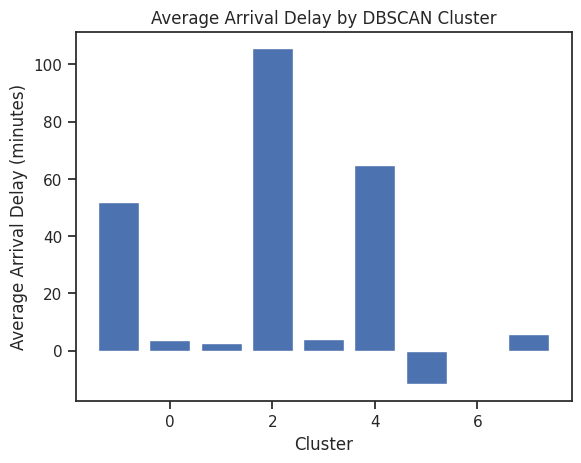

In [38]:
pdf_stats = pdf_stats.toPandas()
plt.figure()
plt.bar(pdf_stats["cluster"], pdf_stats["avg_arrival_delay"])
plt.xlabel("Cluster")
plt.ylabel("Average Arrival Delay (minutes)")
plt.title("Average Arrival Delay by DBSCAN Cluster")
plt.show()

No gráfico:

Cluster 2 → maior atraso médio (≈ 105 min)

Cluster 4 → segundo pior (≈ 65 min)

Cluster -1 → também crítico (≈ 52 min)

Clusters 0 e 1 → operação saudável

Cluster 5 → voos adiantados

In [39]:
# Média de atrasos por aeroporto de origem
airport_stats = (
    df_clustered
    .groupBy("ORIGIN_AIRPORT")
    .agg(
        F.count("*").alias("total_flights"),
        F.avg("DEPARTURE_DELAY").alias("avg_departure_delay"),
        F.avg("ARRIVAL_DELAY").alias("avg_arrival_delay"),
        F.sum(F.when(F.col("cluster").isin([-1, 2, 4]), 1).otherwise(0)).alias("bad_flights"),
        F.sum(F.when(F.col("cluster").isin([5, 6, 7, 1, 3]), 1).otherwise(0)).alias("good_flights")
    )
    .withColumn("bad_rate", F.col("bad_flights") / F.col("total_flights"))
    .withColumn("good_rate", F.col("good_flights") / F.col("total_flights"))
)

# Top 10 piores aeroportos
airport_stats.orderBy(
    F.desc("avg_arrival_delay"),
    F.desc("bad_rate")
).show(10, truncate=False)


+--------------+-------------+-------------------+------------------+-----------+------------+--------------------+---------+
|ORIGIN_AIRPORT|total_flights|avg_departure_delay|avg_arrival_delay |bad_flights|good_flights|bad_rate            |good_rate|
+--------------+-------------+-------------------+------------------+-----------+------------+--------------------+---------+
|COD           |5            |57.2               |59.4              |0          |0           |0.0                 |0.0      |
|GST           |5            |31.4               |37.8              |0          |0           |0.0                 |0.0      |
|INL           |11           |27.545454545454547 |33.54545454545455 |0          |0           |0.0                 |0.0      |
|CMI           |32           |30.5               |31.375            |4          |0           |0.125               |0.0      |
|OAJ           |10           |29.7               |29.2              |1          |0           |0.1                 |0.0

+--------------+-------------+-------------------+-------------------+------------+---------+
|ORIGIN_AIRPORT|total_flights|avg_departure_delay|avg_arrival_delay  |good_flights|good_rate|
+--------------+-------------+-------------------+-------------------+------------+---------+
|CNY           |3            |-8.333333333333334 |-24.333333333333332|0           |0.0      |
|LAR           |4            |-1.75              |-17.75             |0           |0.0      |
|PUB           |6            |-9.166666666666666 |-16.5              |0           |0.0      |
|ACV           |13           |-6.076923076923077 |-16.076923076923077|0           |0.0      |
|BTM           |8            |-5.0               |-14.5              |0           |0.0      |
|PSE           |7            |-5.714285714285714 |-14.428571428571429|0           |0.0      |
|APN           |6            |-9.666666666666666 |-13.666666666666666|0           |0.0      |
|EAU           |7            |-6.142857142857143 |-13.142857

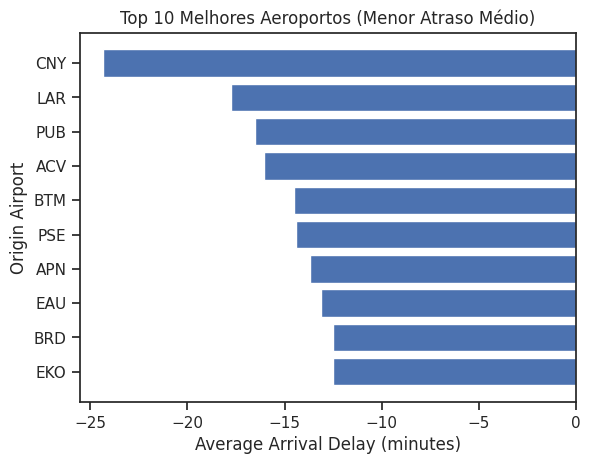

In [40]:
# =========================
# Seleciona os 10 melhores aeroportos
airport_stats = (
    df_clustered
    .groupBy("ORIGIN_AIRPORT")
    .agg(
        F.count("*").alias("total_flights"),
        F.avg("DEPARTURE_DELAY").alias("avg_departure_delay"),
        F.avg("ARRIVAL_DELAY").alias("avg_arrival_delay"),
        F.sum(F.when(F.col("cluster").isin([5, 6, 7, 1, 3]), 1).otherwise(0)).alias("good_flights")
    )
    .withColumn("good_rate", F.col("good_flights") / F.col("total_flights"))
)

best_airports = (
    airport_stats
    .orderBy(
        F.asc("avg_arrival_delay"),   # menor atraso médio
        F.desc("good_rate")           # maior taxa de bons clusters
    )
    .limit(10)
)

best_airports.show(truncate=False)

pdf_best = best_airports.toPandas()

plt.figure()
plt.barh(pdf_best["ORIGIN_AIRPORT"], pdf_best["avg_arrival_delay"])
plt.xlabel("Average Arrival Delay (minutes)")
plt.ylabel("Origin Airport")
plt.title("Top 10 Melhores Aeroportos (Menor Atraso Médio)")
plt.gca().invert_yaxis()   # melhor aeroporto no topo
plt.show()


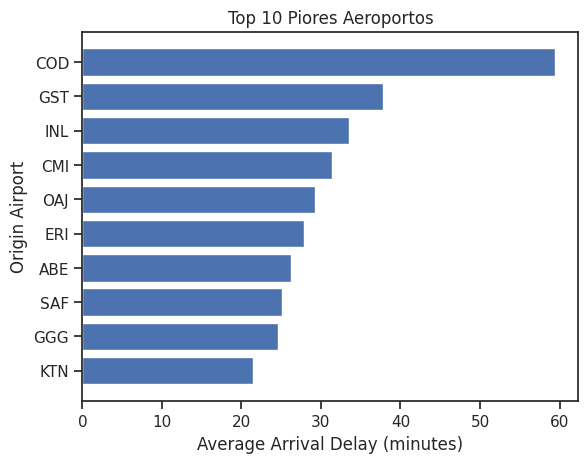

In [41]:
pdf_airports = (
    airport_stats
    .orderBy(F.desc("avg_arrival_delay"))
    .limit(10)
    .toPandas()
)

plt.figure()
plt.barh(pdf_airports["ORIGIN_AIRPORT"], pdf_airports["avg_arrival_delay"])
plt.xlabel("Average Arrival Delay (minutes)")
plt.ylabel("Origin Airport")
plt.title("Top 10 Piores Aeroportos")
plt.gca().invert_yaxis()
plt.show()


    -----------------------------------------------

### 9. Discuta as limitações dos modelos

Limitações do DBSCAN
Sensibilidade aos hiperparâmetros (eps e min_samples)
Resultados mudam bastante conforme o valor de eps. Um eps pequeno → muitos pontos viram ruído (-1). Um eps grande → clusters se fundem e perdem significado.

Impacto: a definição de “melhor” ou “pior” aeroporto pode mudar apenas por escolha de parâmetro, não necessariamente por mudança real nos dados.

Dificuldade com densidades diferentes: DBSCAN funciona melhor quando todos os clusters têm densidade semelhante.

Em dados de voos:

- Grandes aeroportos → alta densidade
- Pequenos aeroportos → baixa densidade

O modelo tende a:

- Agrupar grandes hubs
- Classificar aeroportos menores como ruído (-1), mesmo que não sejam problemáticos
- Rótulos não são “verdades”
- Clusters não representam categorias reais, apenas padrões matemáticos de densidade.

Exemplo:

Um cluster com atraso médio alto não significa automaticamente falha operacional: pode ser clima, tráfego aéreo, sazonalidade, congestionamento regional.

Limitações do PCA:

- Perda de interpretabilidade

Após aplicar PCA:

- Você trabalha com componentes abstratos

Não é mais trivial dizer: “Esse cluster existe por causa de DISTANCE ou TAXI_OUT”

Isso dificulta explicar causa operacional.

Preserva variância, não relevância operacional

O PCA: Maximiza variância estatística, Não necessariamente preserva: fatores críticos para atraso, impacto de clima, efeitos logísticos reais.

### 10. Proponha melhorias e próximos passos

Melhorias nos Dados
- Enriquecer com variáveis externas

Hoje você explica atraso só com variáveis operacionais. Para tornar a análise mais realista:

Adicionar:

- Clima (chuva, vento, neve, tempestades)
- Horário do voo (pico vs madrugada)
- Dia da semana / sazonalidade
- Capacidade do aeroporto / volume horário
- Região geográfica
- Isso reduz viés e melhora a explicação dos clusters.

Melhorias no Modelo
- Trocar ou complementar o DBSCAN
- HDBSCAN

Melhor para densidades diferentes

- Menos sensível a eps
- Mantém detecção de ruído

Ideal para dados com grandes hubs + aeroportos pequenos.

Comparar com K-Means

Rodar:

- K-Means (k fixo)
- DBSCAN / HDBSCAN (densidade)

Comparar:

- Silhouette Score
- Estabilidade dos grupos

Coerência operacional

- Mostra maturidade metodológica.

    ----------------------------------

# Análise livre e criação de mapas geográficos de rotas e atrasos

In [60]:
from pyspark.sql import functions as F
import folium

# Agrega por aeroporto de origem (pode repetir para destino se quiser)
df_airports = (
    df_clean
    .groupBy("ORIGIN_AIRPORT", "ORIGIN_LATITUDE", "ORIGIN_LONGITUDE")
    .agg(
        F.count("*").alias("num_flights"),
        F.avg("ARRIVAL_DELAY").alias("avg_arrival_delay")
    )
    .filter(F.col("num_flights") > 30)  # remove aeroportos com poucos voos
)

pdf_airports = df_airports.toPandas()

# Centro aproximado dos EUA
m = folium.Map(location=[39.5, -98.35], zoom_start=4)

for _, row in pdf_airports.iterrows():
    color = "red" if row["avg_arrival_delay"] > 15 else "green"

    folium.CircleMarker(
        location=[row["ORIGIN_LATITUDE"], row["ORIGIN_LONGITUDE"]],
        radius=6,
        color=color,
        fill=True,
        fill_opacity=0.7,
        tooltip=(
            f"Aeroporto: {row['ORIGIN_AIRPORT']}<br>"
            f"Voos: {row['num_flights']}<br>"
            f"Atraso médio: {row['avg_arrival_delay']:.1f} min"
        )
    ).add_to(m)

m.save("mapa_aeroportos.html")


In [61]:
from pyspark.sql import functions as F
import folium

# Agrega por aeroporto de origem (pode repetir para destino se quiser)
df_airports = (
    df_clean
    .groupBy("ORIGIN_AIRPORT", "ORIGIN_LATITUDE", "ORIGIN_LONGITUDE")
    .agg(
        F.count("*").alias("num_flights"),
        F.avg("ARRIVAL_DELAY").alias("avg_arrival_delay")
    )
    .filter(F.col("num_flights") > 30)  # remove aeroportos com poucos voos
)

pdf_airports = df_airports.toPandas()

# Centro aproximado dos EUA
m = folium.Map(location=[39.5, -98.35], zoom_start=4)

for _, row in pdf_airports.iterrows():
    color = "red" if row["avg_arrival_delay"] > 15 else "green"

    folium.CircleMarker(
        location=[row["ORIGIN_LATITUDE"], row["ORIGIN_LONGITUDE"]],
        radius=6,
        color=color,
        fill=True,
        fill_opacity=0.7,
        tooltip=(
            f"Aeroporto: {row['ORIGIN_AIRPORT']}<br>"
            f"Voos: {row['num_flights']}<br>"
            f"Atraso médio: {row['avg_arrival_delay']:.1f} min"
        )
    ).add_to(m)

m.save("mapa_aeroportos.html")

### Identificar padrões sazonais e horários críticos

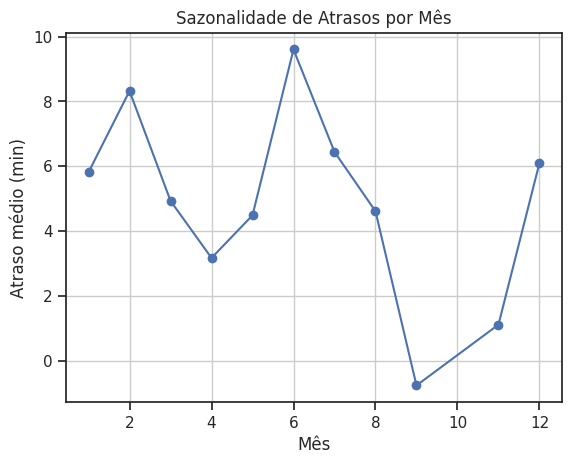

In [46]:
df_month = (
    df_clean
    .groupBy("MONTH")
    .agg(
        F.avg("ARRIVAL_DELAY").alias("avg_arrival_delay"),
        F.count("*").alias("num_flights")
    )
    .orderBy("MONTH")
)

pdf_month = df_month.toPandas()

plt.figure()
plt.plot(pdf_month["MONTH"], pdf_month["avg_arrival_delay"], marker="o")
plt.xlabel("Mês")
plt.ylabel("Atraso médio (min)")
plt.title("Sazonalidade de Atrasos por Mês")
plt.grid(True)
plt.show()

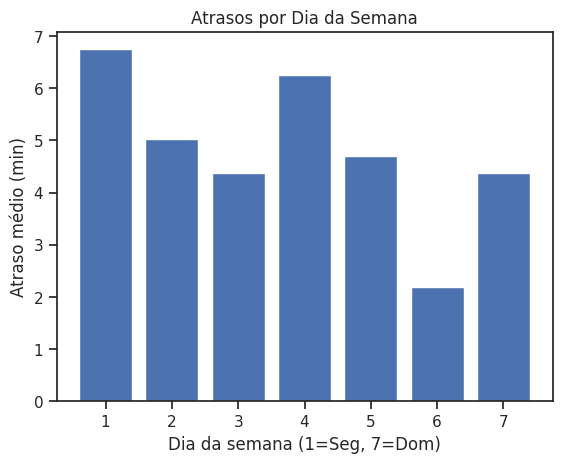

In [47]:
df_weekday = (
    df_clean
    .groupBy("DAY_OF_WEEK")
    .agg(F.avg("ARRIVAL_DELAY").alias("avg_arrival_delay"))
    .orderBy("DAY_OF_WEEK")
)

pdf_weekday = df_weekday.toPandas()

plt.figure()
plt.bar(pdf_weekday["DAY_OF_WEEK"], pdf_weekday["avg_arrival_delay"])
plt.xlabel("Dia da semana (1=Seg, 7=Dom)")
plt.ylabel("Atraso médio (min)")
plt.title("Atrasos por Dia da Semana")
plt.show()